In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from imblearn.over_sampling import SMOTE

In [11]:
df = pd.read_csv('spotify_songs.csv')
df.head()

,track_id,track_name,artists,track_genre,danceability,energy,speechiness,acousticness,instrumentalness,valence,norm_popularity,norm_tempo,norm_loudness
0,3nqQXoyQOWXiESFLlDF1hG,Unholy (feat. Kim Petras),Sam Smith;Kim Petras,dance,0.714,0.472,0.0864,0.01300,0.000005,0.238,1.00,0.524484,0.877083
1,2tTmW7RDtMQtBk7m2rYeSw,"Quevedo: Bzrp Music Sessions, Vol. 52",Bizarrap;Quevedo,hip-hop,0.621,0.782,0.0440,0.01250,0.033000,0.550,0.99,0.512132,0.907533
2,5ww2BF9slyYgNOk37BlC4u,La Bachata,Manuel Turizo,latin,0.835,0.679,0.0364,0.58300,0.000002,0.850,0.98,0.499920,0.911183
3,4uUG5RXrOk84mYEfFvj3cK,I'm Good (Blue),David Guetta;Bebe Rexha,dance,0.561,0.965,0.0343,0.00383,0.000007,0.304,0.98,0.512160,0.938783
4,1IHWl5LamUGEuP4ozKQSXZ,Tití Me Preguntó,Bad Bunny,latin,0.650,0.715,0.2530,0.09930,0.000291,0.187,0.97,0.426688,0.913367


In [ ]:
threshold = df['norm_popularity'].quantile(0.75)
df['is_hit'] = (df['norm_popularity'] >= threshold).astype(int)

# 3. Feature Engineering: Creating "Vibe" Signals
df['energy_acoustic_ratio'] = df['energy'] / (df['acousticness'] + 0.1)
df['positivity_index'] = df['danceability'] * df['valence']
artist_counts = df['artists'].value_counts().to_dict()
df['artist_presence'] = df['artists'].map(artist_counts)


In [ ]:
features = [
    'danceability', 'energy', 'norm_loudness', 'speechiness', 
    'acousticness', 'instrumentalness', 'valence', 'norm_tempo', 'artist_presence', 'energy_acoustic_ratio', 'positivity_index'
]
X = df[features]
y = df['is_hit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
}

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=3,  
    eval_metric='logloss',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    verbose=1
)

In [66]:
grid_search.fit(X_train, y_train)

# 4. Results & Best Model
print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


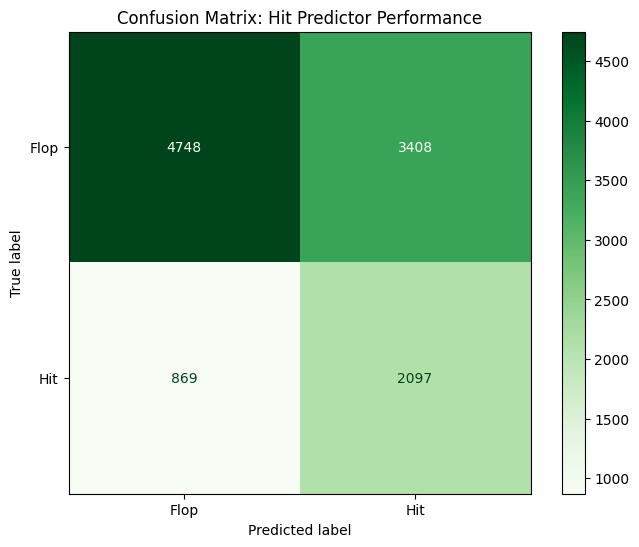

In [67]:
# 8. Visualize the Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    best_model, 
    X_test, 
    y_test, 
    display_labels=['Flop', 'Hit'], 
    cmap='Greens',
    ax=ax
)
plt.title("Confusion Matrix: Hit Predictor Performance")
plt.show()

In [68]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.58      0.69      8156
           1       0.38      0.71      0.50      2966

    accuracy                           0.62     11122
   macro avg       0.61      0.64      0.59     11122
weighted avg       0.72      0.62      0.64     11122



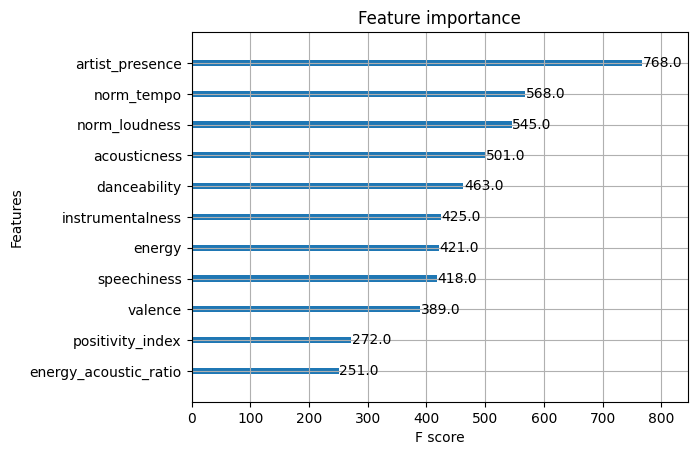

In [69]:
xgb.plot_importance(best_model)
plt.show()

In [70]:
joblib.dump(best_model, 'hit_predictor_model.joblib')
model_features = X.columns.tolist()
joblib.dump(model_features, 'model_features.joblib')

['model_features.joblib']